In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import joblib
import shap
import lime
import lime.lime_tabular
import warnings
from sklearn.tree import DecisionTreeRegressor
import os
warnings.filterwarnings("ignore", message="use_inf_as_na option is deprecated", category=FutureWarning)
shap.initjs()
%matplotlib inline

# Set matplotlib backend to 'Agg' to prevent display issues in headless environments
plt.switch_backend('Agg')

# 1. Data Loading and Initial Exploration
This section loads the raw dataset and performs an initial inspection to understand its structure, identify missing values, and get a statistical summary.

In [2]:
# Load the dataset
df = pd.read_csv("/kaggle/input/fantasy-football/cleaned_merged_seasons.csv")

# Display basic information about the dataset
print('Dataset Head:')
print(df.head())

print('\nDataset Info:')
df.info()

print('\nDataset Description:')
print(df.describe())

print('\nMissing values before cleaning:')
print(df.isnull().sum())

Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.


Dataset Head:
  season_x                name position team_x  assists  bonus  bps  \
0  2016-17     Aaron Cresswell      DEF    NaN        0      0    0   
1  2016-17        Aaron Lennon      MID    NaN        0      0    6   
2  2016-17        Aaron Ramsey      MID    NaN        0      0    5   
3  2016-17  Abdoulaye Doucouré      MID    NaN        0      0    0   
4  2016-17        Adam Forshaw      MID    NaN        0      0    3   

   clean_sheets  creativity  element  ...  team_h_score  threat  total_points  \
0             0         0.0      454  ...           2.0     0.0             0   
1             0         0.3      142  ...           1.0     0.0             1   
2             0         4.9       16  ...           3.0    23.0             2   
3             0         0.0      482  ...           1.0     0.0             0   
4             0         1.3      286  ...           1.0     0.0             1   

   transfers_balance  transfers_in transfers_out  value  was_home  \
0  

In [3]:
# --- Data Cleaning ---
# Drop 'team_x' column as it has many null values and is not needed for analysis
df = df.drop(columns=['team_x'], errors='ignore')

# Handle duplicates
df.drop_duplicates(inplace=True)

# Convert 'kickoff_time' to datetime
df['kickoff_time'] = pd.to_datetime(df['kickoff_time'])

# Sort data for correct calculation of 'form' and 'upcoming_total_points'
df.sort_values(by=['name', 'season_x', 'GW'], inplace=True)

# --- Data Engineering ---
# Add 'form' column
df['form'] = df.groupby(['name', 'season_x'])['total_points'].rolling(window=4, min_periods=1).mean().reset_index(level=[0,1], drop=True)
df['form'] = df['form'] / 10

# Create the target variable: upcoming_total_points
df['upcoming_total_points'] = df.groupby(['name', 'season_x'])['total_points'].shift(-1)

# Drop the last week for each player/season where upcoming_total_points is NaN
df.dropna(subset=['upcoming_total_points'], inplace=True)

print("Data cleaning and engineering complete.")
print("Missing values after cleaning:")
print(df.isnull().sum())
print("First few rows with 'form' and 'upcoming_total_points' columns:")
print(df[['name', 'season_x', 'GW', 'total_points', 'form', 'upcoming_total_points']].head(10))

Data cleaning and engineering complete.
Missing values after cleaning:
season_x                 0
name                     0
position                 0
assists                  0
bonus                    0
bps                      0
clean_sheets             0
creativity               0
element                  0
fixture                  0
goals_conceded           0
goals_scored             0
ict_index                0
influence                0
kickoff_time             0
minutes                  0
opponent_team            0
opp_team_name            0
own_goals                0
penalties_missed         0
penalties_saved          0
red_cards                0
round                    0
saves                    0
selected                 0
team_a_score             0
team_h_score             0
threat                   0
total_points             0
transfers_balance        0
transfers_in             0
transfers_out            0
value                    0
was_home                 0
yellow_card

Any infinities left: False
Generating visualizations for cleaned data...
No missing values after cleaning!


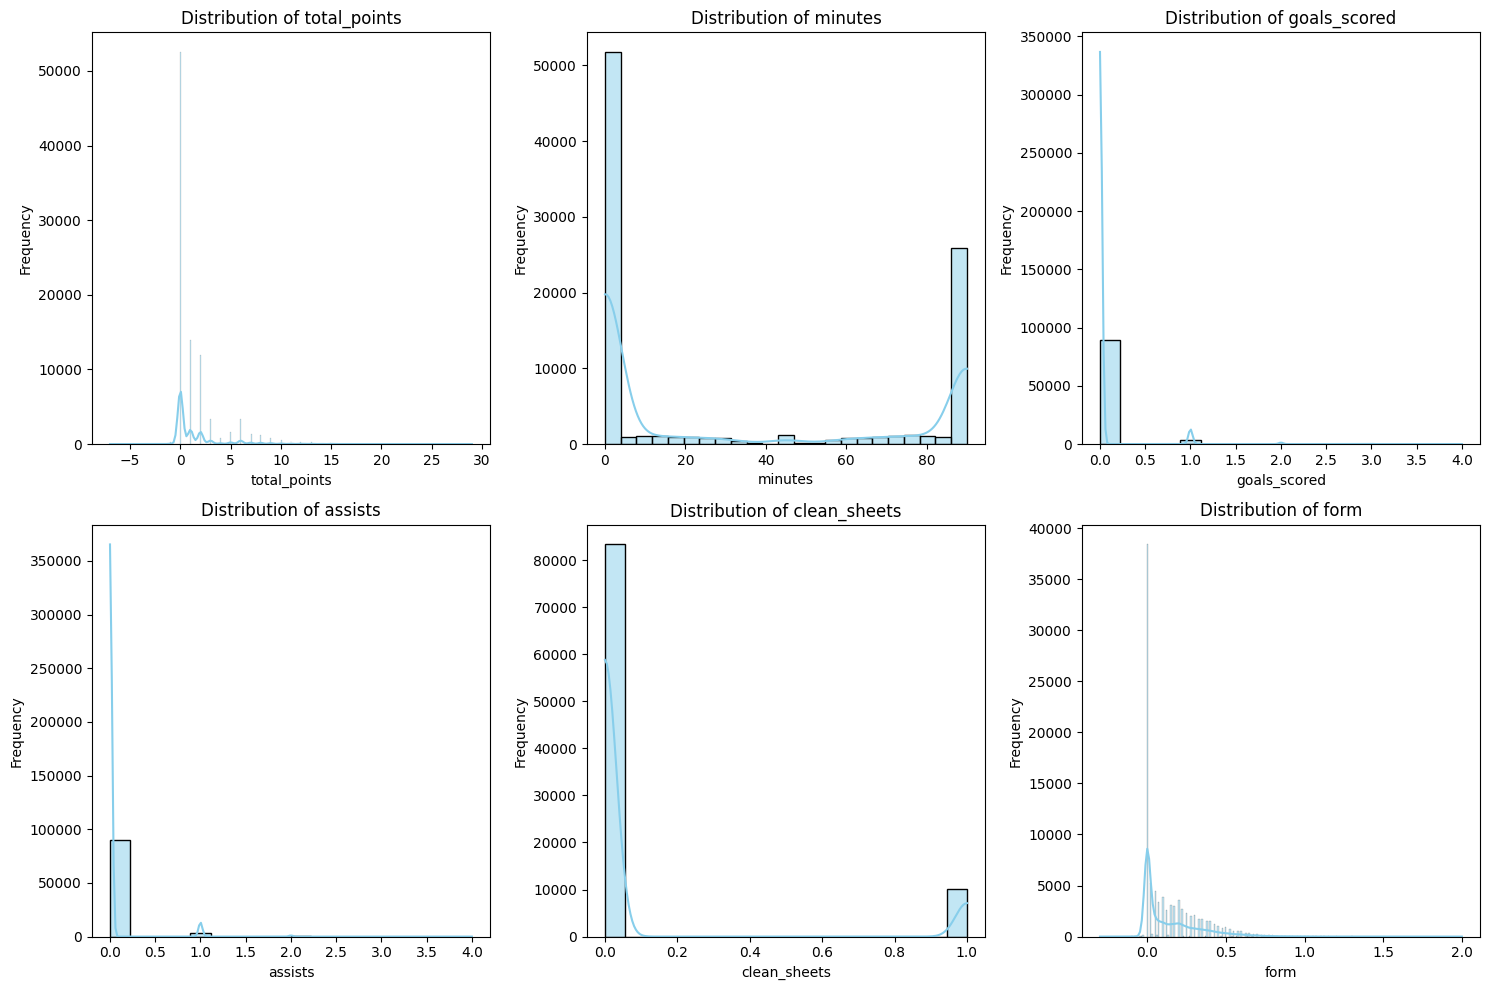

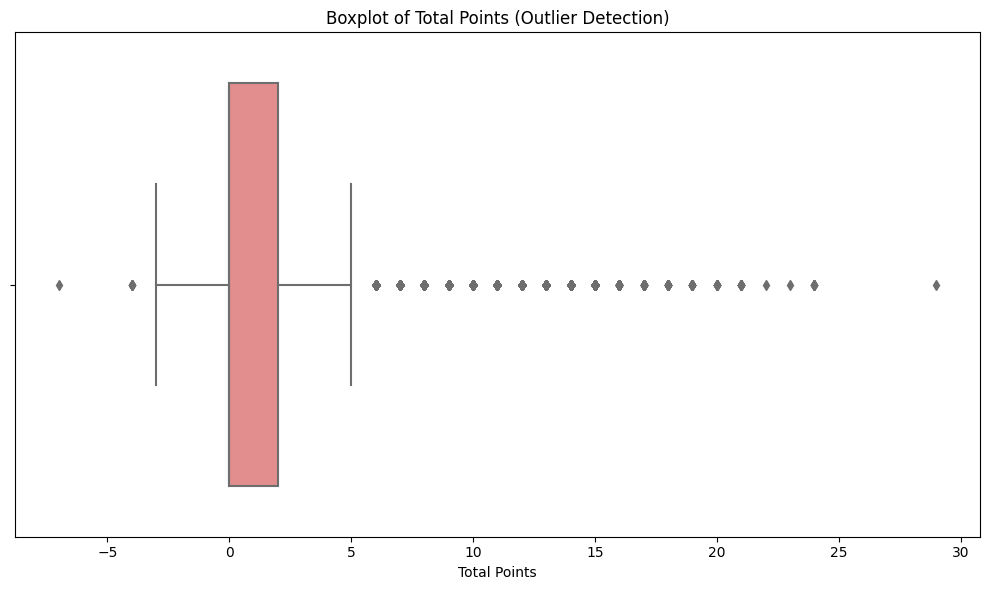

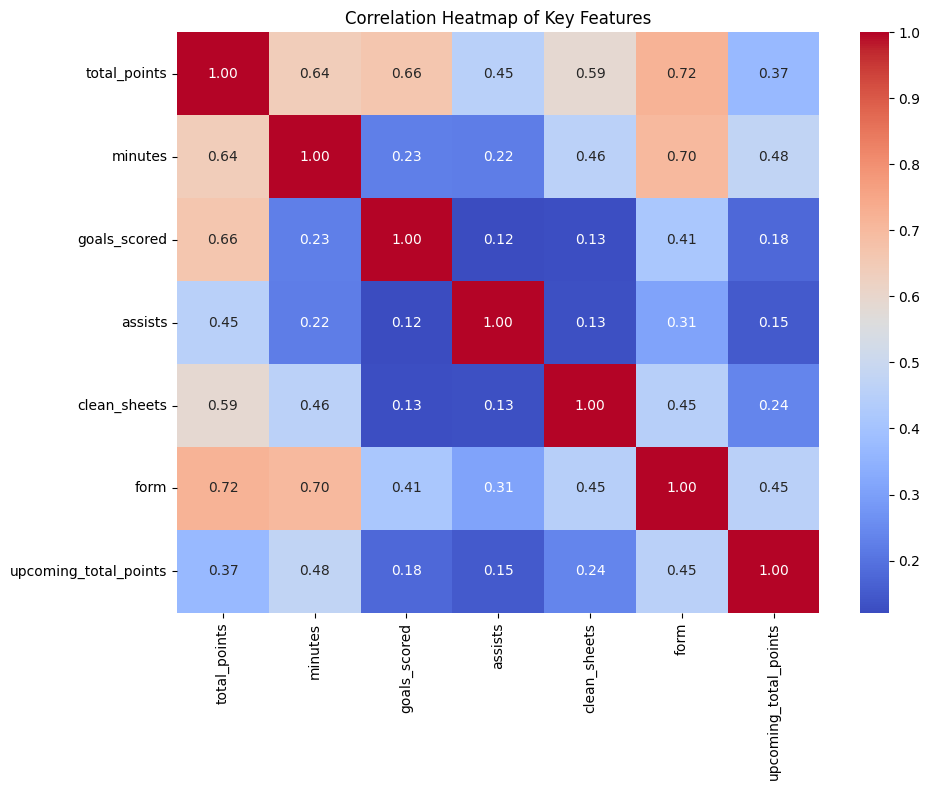

Data cleaning visualizations complete.


In [4]:
# Ensure inline display
%matplotlib inline

# --- Clean up previous figures ---
plt.close('all')

# --- Clean infinities ---
df = df.replace([np.inf, -np.inf], np.nan)
df = df.dropna(how='all')  # Optional
print("Any infinities left:", np.isinf(df.select_dtypes(include=[np.number])).values.any())

print("Generating visualizations for cleaned data...")

# --- Missing Values ---
missing_counts = df.isnull().sum()
missing_counts = missing_counts[missing_counts > 0].sort_values(ascending=False)

if len(missing_counts) > 0:
    plt.figure(figsize=(12, 6))
    sns.barplot(x=missing_counts.values, y=missing_counts.index, palette='Reds_r')
    plt.title('Missing Values After Cleaning')
    plt.xlabel('Count of Missing Values')
    plt.ylabel('Features')
    plt.tight_layout()
    plt.show()
    plt.close()
else:
    print("No missing values after cleaning!")

# --- Distributions ---
numerical_features = ['total_points', 'minutes', 'goals_scored', 'assists', 'clean_sheets', 'form', 'upcoming_total_points']
existing_num_features = [f for f in numerical_features if f in df.columns]

if existing_num_features:
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.flatten()
    
    for idx, feature in enumerate(existing_num_features[:6]):
        sns.histplot(df[feature].dropna(), kde=True, ax=axes[idx], color='skyblue')
        axes[idx].set_title(f'Distribution of {feature}')
        axes[idx].set_xlabel(feature)
        axes[idx].set_ylabel('Frequency')
    
    for idx in range(len(existing_num_features), 6):
        axes[idx].axis('off')
    
    plt.tight_layout()
    plt.show()
    plt.close()
else:
    print("No numerical features found for distribution plots.")

# --- Boxplot ---
if 'total_points' in df.columns:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=df['total_points'], color='lightcoral')
    plt.title('Boxplot of Total Points (Outlier Detection)')
    plt.xlabel('Total Points')
    plt.tight_layout()
    plt.show()
    plt.close()



# --- Correlation Heatmap ---
plt.figure(figsize=(10, 8))
corr = df[existing_num_features].corr()
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title('Correlation Heatmap of Key Features')
plt.tight_layout()
plt.show()
plt.close()

print("Data cleaning visualizations complete.")

# 2. Data Cleaning and Feature Engineering
This section focuses on preparing the data for analysis and modeling. It includes steps to handle missing values, remove duplicates, convert data types, and create new features as specified in the project requirements.

## Data Cleaning
- **Remove unnecessary columns**: The `team_x` column is removed due to a high number of null values and its irrelevance to player performance. Columns like `selected_by_percent`, `transfers_in`, and `transfers_out` are kept as per user request.
- **Remove duplicates**: Ensures data integrity.
- **Convert data types**: `kickoff_time` is converted to datetime objects.
- **Sort data**: The dataset is sorted by player name, season, and gameweek to facilitate accurate rolling calculations for the `form` feature.

## Feature Engineering
- **`form` column**: Calculated as the average total points over the past four gameweeks, divided by 10. This metric reflects a player\`s recent performance trend.
- **`upcoming_total_points`**: The target variable, representing the `total_points` a player scored in the *following* gameweek. Rows without an upcoming week are dropped.

# 3. Data Engineering Questions Analysis
This section addresses specific analytical questions using the prepared dataset, providing insights into player performance trends and positional contributions.

## a. Player Positions with Largest Average Total Points
This analysis identifies which player positions consistently score the highest average total points across all seasons, providing insights into FPL scoring dynamics.

Average Total Points per Player Position (Across all seasons):
position
FWD    1.568827
MID    1.453792
DEF    1.296652
GK     1.167643
GKP    0.712871
Name: total_points, dtype: float64


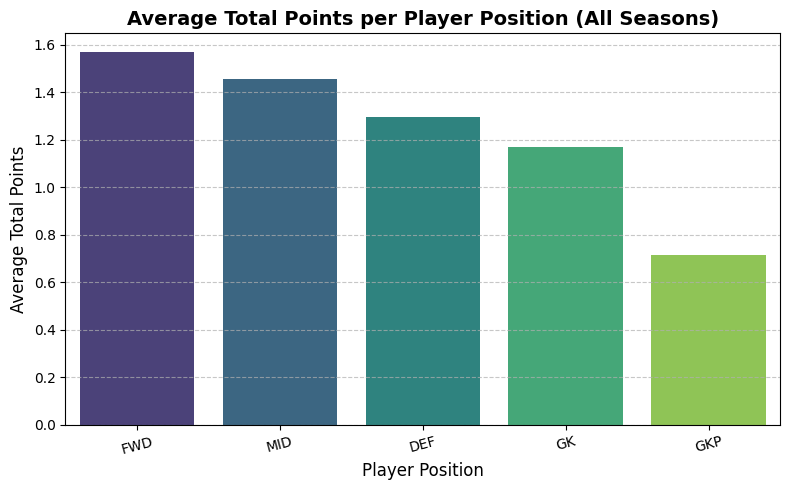

In [5]:
# --- Question a: Player positions with largest sum of total points on average across seasons ---

avg_points_per_position = df.groupby("position")["total_points"].mean().sort_values(ascending=False)

print("Average Total Points per Player Position (Across all seasons):")
print(avg_points_per_position)

# --- Visualization: Average Total Points per Player Position ---
plt.close('all')  

plt.figure(figsize=(8, 5))
sns.barplot(
    x=avg_points_per_position.index,
    y=avg_points_per_position.values,
    palette="viridis"
)
plt.title("Average Total Points per Player Position (All Seasons)", fontsize=14, weight='bold')
plt.xlabel("Player Position", fontsize=12)
plt.ylabel("Average Total Points", fontsize=12)
plt.xticks(rotation=15)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show(block=False)  

- # Answer to question A:
The player position with the most anount of total points on average is the FWD postion

## b. Performance Evolution of Top Five Players (2022-23 Season)
This part examines how the `form` and `total_points` of the top five players evolved during the 2022-23 FPL season, comparing players identified by total points versus those identified by average form.

Top 5 Players by Total Points (2022-23 Season): ['Erling Haaland', 'Harry Kane', 'Mohamed Salah', 'Martin Ødegaard', 'Marcus Rashford']
Top 5 Players by Average Form (2022-23 Season): ['Erling Haaland', 'Harry Kane', 'Mohamed Salah', 'Martin Ødegaard', 'Gabriel Martinelli Silva']
The top players in form are NOT the same as the top players with the highest total points in 2022-23 season.


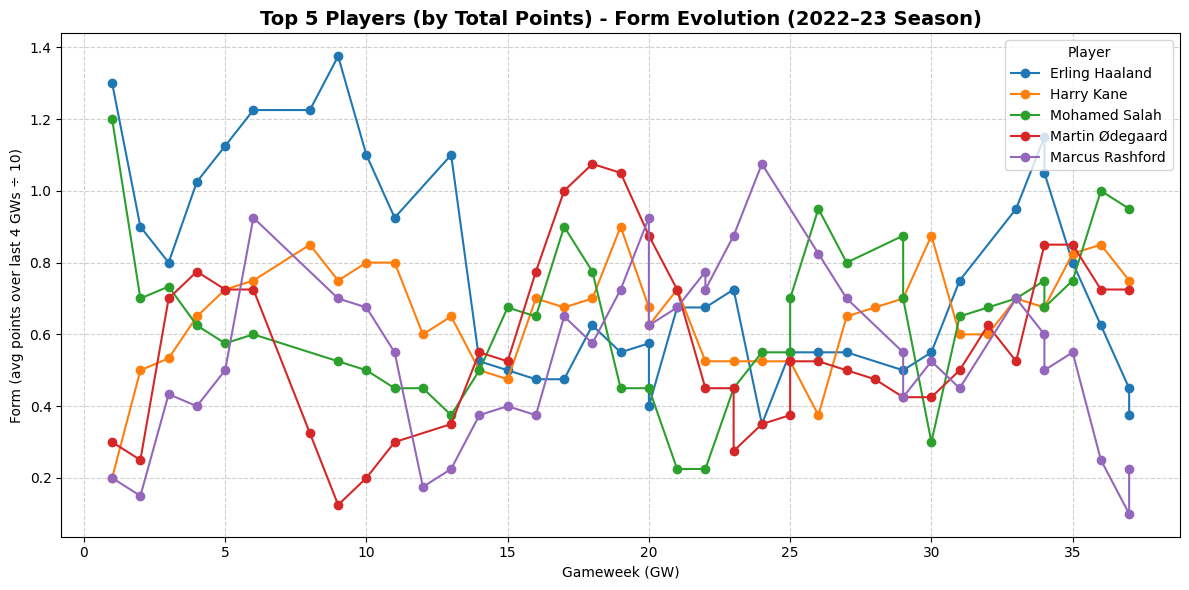

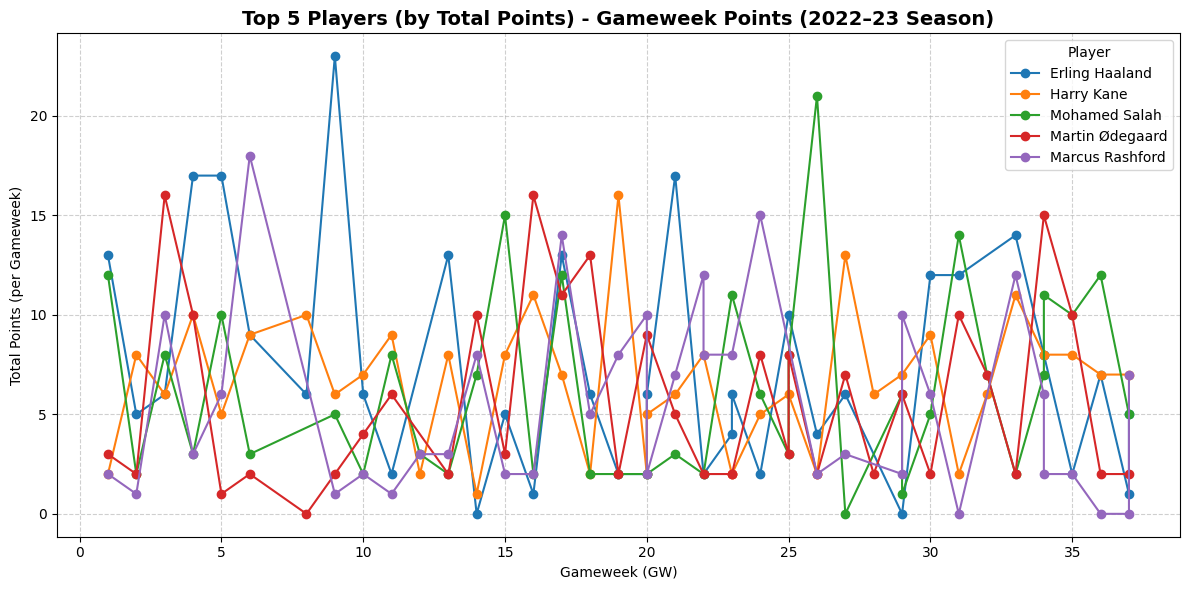

In [6]:
# --- Question b: Performance of top five players (form vs. total points) in 2022-23 season ---
%matplotlib inline
df_22_23 = df[df["season_x"] == "2022-23"]

top_5_total_points_22_23 = df_22_23.groupby("name")["total_points"].sum().nlargest(5).index.tolist()
top_5_form_22_23 = df_22_23.groupby("name")["form"].mean().nlargest(5).index.tolist()

print("Top 5 Players by Total Points (2022-23 Season):", top_5_total_points_22_23)
print("Top 5 Players by Average Form (2022-23 Season):", top_5_form_22_23)

if set(top_5_total_points_22_23) == set(top_5_form_22_23):
    print("The top players in form are the same as the top players with the highest total points in 2022-23 season.")
else:
    print("The top players in form are NOT the same as the top players with the highest total points in 2022-23 season.")

# --- Visualization 1: Form evolution of top 5 players ---
plt.figure(figsize=(12, 6))
for player_name in top_5_total_points_22_23:
    player_data = df_22_23[df_22_23["name"] == player_name]
    plt.plot(player_data["GW"], player_data["form"], label=player_name, marker="o")
plt.title("Top 5 Players (by Total Points) - Form Evolution (2022–23 Season)", fontsize=14, weight='bold')
plt.xlabel("Gameweek (GW)")
plt.ylabel("Form (avg points over last 4 GWs ÷ 10)")
plt.legend(title="Player")
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.savefig("top_5_players_form_22_23.png")
plt.show()

# --- Visualization 2: Total points per gameweek for top 5 players ---
plt.figure(figsize=(12, 6))
for player_name in top_5_total_points_22_23:
    player_data = df_22_23[df_22_23["name"] == player_name]
    plt.plot(player_data["GW"], player_data["total_points"], label=player_name, marker="o")
plt.title("Top 5 Players (by Total Points) - Gameweek Points (2022–23 Season)", fontsize=14, weight='bold')
plt.xlabel("Gameweek (GW)")
plt.ylabel("Total Points (per Gameweek)")
plt.legend(title="Player")
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.savefig("top_5_players_total_points_22_23.png")
plt.show()
plt.close('all')



- # Answer to question B:
The top players in form are NOT the same as the top players with the highest total points in 2022-23 season.

# 4. Predictive Modeling Task
This section details the development of a predictive model for `upcoming_total_points`. It covers feature selection, encoding of categorical variables, model training, and evaluation.

## Feature Selection and Encoding
Features are selected based on their relevance to player performance, categorized into match-related and player-related attributes. The `position` categorical feature is one-hot encoded to be compatible with machine learning models.

## Model Development
A Random Forest Regressor model is chosen for its robustness and ability to handle complex relationships within the data. The data is split into training and testing sets to ensure unbiased evaluation.

## Model Evaluation
The model\`s performance is assessed using standard regression metrics: Mean Absolute Error (MAE), Mean Squared Error (MSE), Root Mean Squared Error (RMSE), and R-squared (R²). The trained model is then saved for future inference.

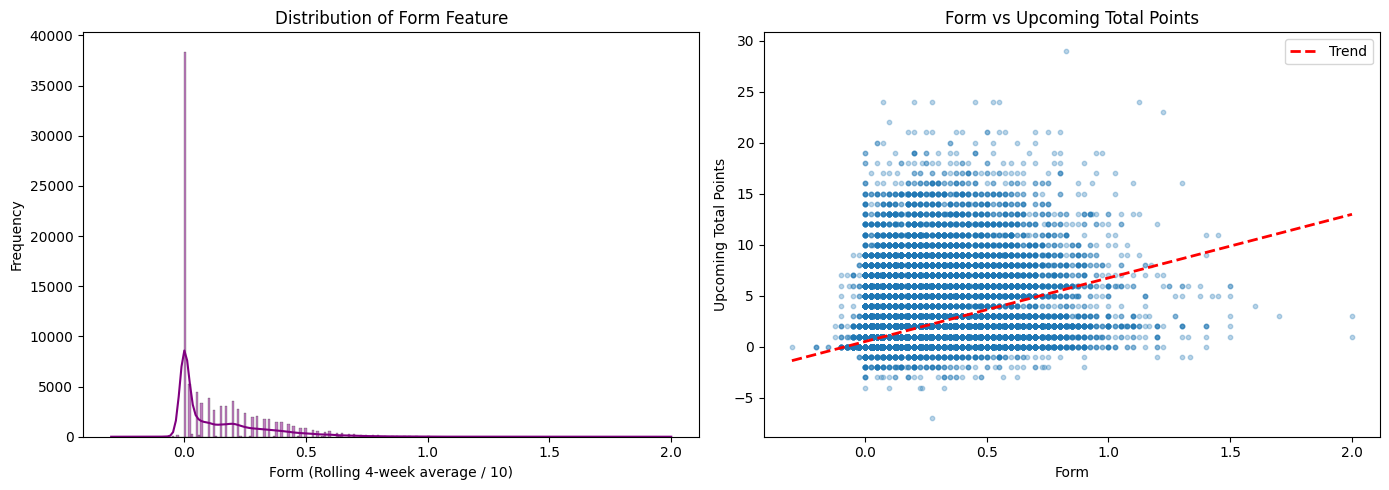

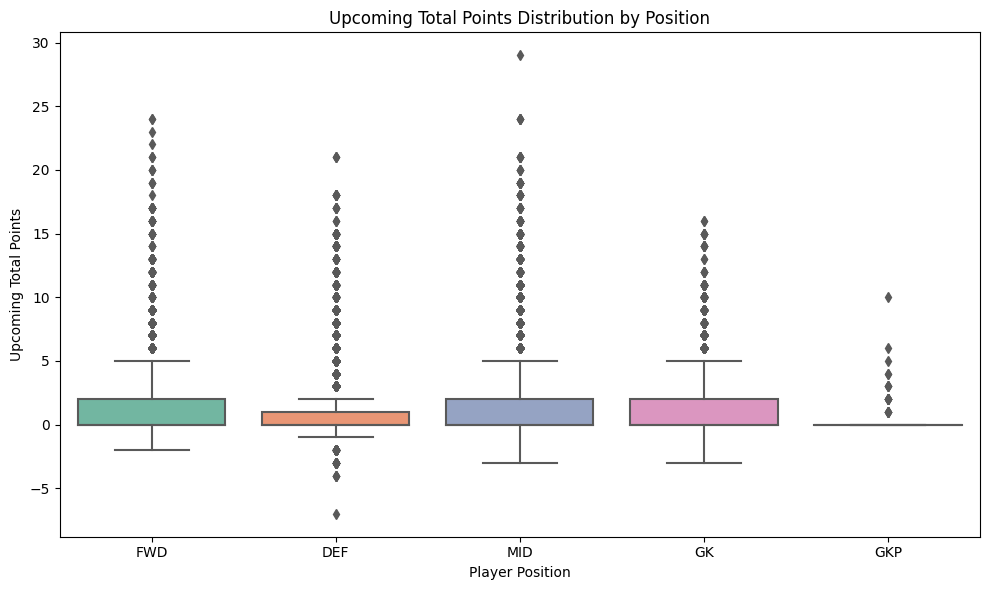


Upcoming Points Statistics by Position:
              mean       std  median
position                            
DEF       1.294299  2.492934     0.0
FWD       1.568502  2.842780     0.0
GK        1.165007  2.363078     0.0
GKP       0.643564  1.513831     0.0
MID       1.454634  2.526483     0.0

Exploratory Data Analysis for feature selection complete.


In [7]:
# Create the 'figures' directory if it doesn't exist
os.makedirs('figures', exist_ok=True)
# Visualize distribution of form feature and its effect
if 'form' in df.columns and 'upcoming_total_points' in df.columns:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Distribution of form
    sns.histplot(df['form'], kde=True, ax=axes[0], color='purple')
    axes[0].set_title('Distribution of Form Feature')
    axes[0].set_xlabel('Form (Rolling 4-week average / 10)')
    axes[0].set_ylabel('Frequency')
    
    # Relationship between form and upcoming points
    axes[1].scatter(df['form'], df['upcoming_total_points'], alpha=0.3, s=10)
    axes[1].set_title('Form vs Upcoming Total Points')
    axes[1].set_xlabel('Form')
    axes[1].set_ylabel('Upcoming Total Points')
    
    # Add trend line
    z = np.polyfit(df['form'].dropna(), df.loc[df['form'].notna(), 'upcoming_total_points'], 1)
    p = np.poly1d(z)
    axes[1].plot(df['form'].sort_values(), p(df['form'].sort_values()), 
                 "r--", linewidth=2, label='Trend')
    axes[1].legend()
    
    plt.tight_layout()
    plt.savefig('figures/form_feature_analysis.png')
    plt.show()
    plt.close()

# Analyze position-based performance
if 'position' in df.columns and 'upcoming_total_points' in df.columns:
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=df, x='position', y='upcoming_total_points', palette='Set2')
    plt.title('Upcoming Total Points Distribution by Position')
    plt.xlabel('Player Position')
    plt.ylabel('Upcoming Total Points')
    plt.tight_layout()
    plt.savefig('figures/position_vs_target.png')
    plt.show()
    plt.close()
    
    # Statistical summary by position
    position_stats = df.groupby('position')['upcoming_total_points'].agg(['mean', 'std', 'median'])
    print("\nUpcoming Points Statistics by Position:")
    print(position_stats)

print("\nExploratory Data Analysis for feature selection complete.")

Features selected and encoded.
Shape of X: (93387, 15)
Shape of y: (93387,)
First 5 rows of X:
        goals_scored  assists  clean_sheets  goals_conceded  minutes  was_home  \
19852             0        0             0               2       45      True   
20277             1        0             1               0       89     False   
20816             0        0             0               2       73      True   
21370             0        0             0               3       65     False   
21932             0        1             0               0       12     False   

       creativity  influence  threat  value      form  position_FWD  \
19852         0.3        1.2    32.0     55  0.100000          True   
20277        11.3       34.8    23.0     55  0.450000          True   
20816        12.1        0.0     8.0     55  0.366667          True   
21370         0.3        3.0     4.0     55  0.325000          True   
21932        10.3       17.2     2.0     55  0.400000         

invalid value encountered in less


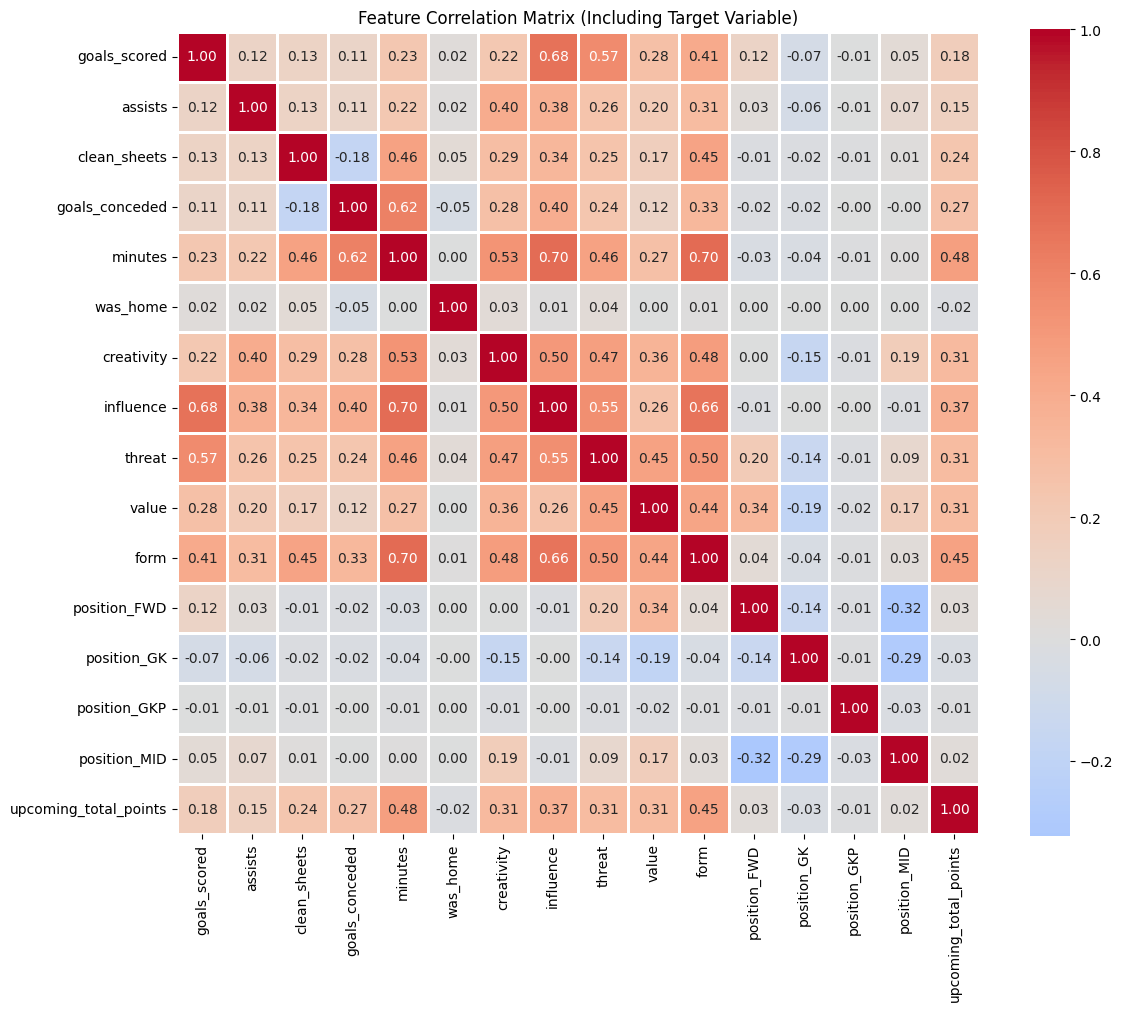


 Correlation with 'upcoming_total_points':
minutes           0.477763
form              0.454657
influence         0.374968
creativity        0.314187
value             0.312058
threat            0.307431
goals_conceded    0.269043
clean_sheets      0.239553
goals_scored      0.177151
assists           0.149466
position_FWD      0.028739
position_MID      0.024052
position_GKP     -0.009536
was_home         -0.016303
position_GK      -0.029773
Name: upcoming_total_points, dtype: float64


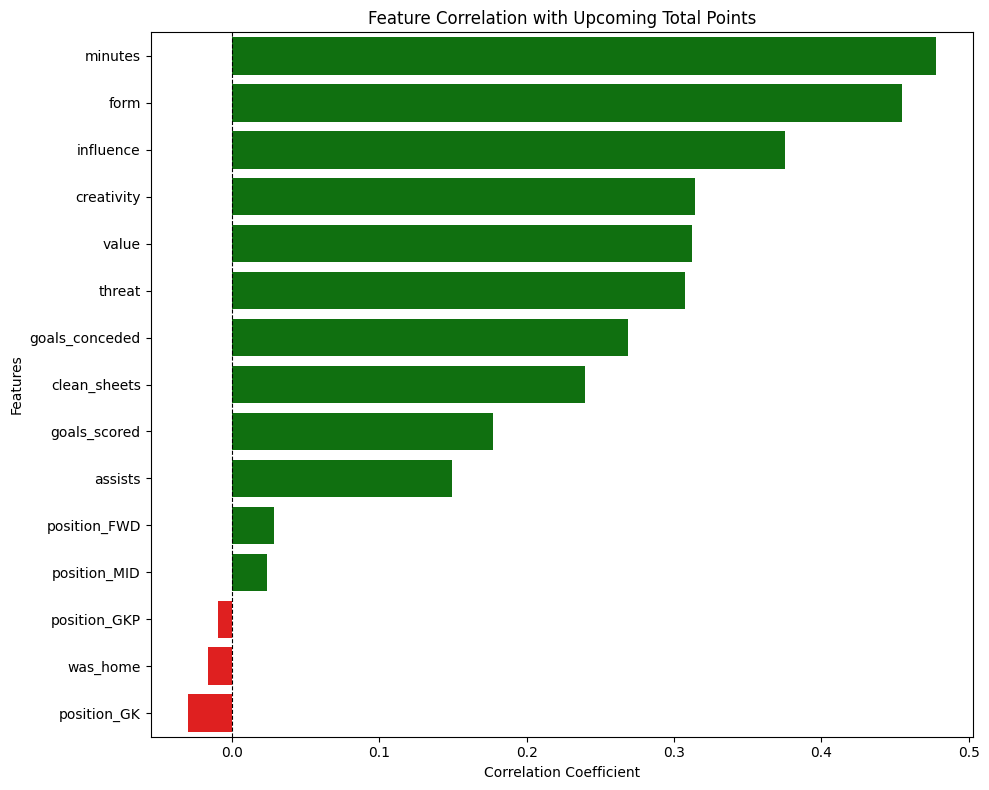


 Feature selection and correlation analysis complete.


In [8]:
# Define the core features (same as your original logic)
features = [
    "goals_scored", "assists", "clean_sheets", "goals_conceded", 
    "minutes", "was_home", "creativity", "influence", 
    "threat", "value", "form"
]

# One-hot encode the 'position' column
if 'position' in df.columns:
    df = pd.get_dummies(df, columns=["position"], drop_first=True)

# Add the one-hot encoded position columns to the features list
position_cols = [col for col in df.columns if col.startswith("position_")]
features.extend(position_cols)

# Define X and y
X = df[features]
y = df["upcoming_total_points"]

print("Features selected and encoded.")
print("Shape of X:", X.shape)
print("Shape of y:", y.shape)
print("First 5 rows of X:\n", X.head())
print("First 5 rows of y:\n", y.head())

# Save feature names for inference
with open("model_features.txt", "w") as f:
    for feature in X.columns:
        f.write(f"{feature}\n")

# --- Correlation Analysis (Visualization Section) ---
print("\n Performing correlation analysis...")

# Make sure there are no infinite values
df = df.replace([np.inf, -np.inf], np.nan)

# Only include features that exist in df
existing_features = [f for f in features if f in df.columns]

# Add target variable for correlation
if "upcoming_total_points" in df.columns and "upcoming_total_points" not in existing_features:
    existing_features.append("upcoming_total_points")

# Compute correlation matrix
corr_matrix = df[existing_features].corr()

# --- Full correlation heatmap ---
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", 
            center=0, square=True, linewidths=1)
plt.title("Feature Correlation Matrix (Including Target Variable)")
plt.tight_layout()
plt.show()

# --- Focused correlation with target variable ---
if "upcoming_total_points" in corr_matrix.columns:
    target_corr = corr_matrix["upcoming_total_points"].drop("upcoming_total_points").sort_values(ascending=False)

    print("\n Correlation with 'upcoming_total_points':")
    print(target_corr)

    plt.figure(figsize=(10, 8))
    colors = ['green' if x > 0 else 'red' for x in target_corr.values]
    sns.barplot(x=target_corr.values, y=target_corr.index, palette=colors)
    plt.title("Feature Correlation with Upcoming Total Points")
    plt.xlabel("Correlation Coefficient")
    plt.ylabel("Features")
    plt.axvline(x=0, color='black', linestyle='--', linewidth=0.8)
    plt.tight_layout()
    plt.show()

print("\n Feature selection and correlation analysis complete.")

Validation Performance:
  MAE  (Validation): 1.2533
  MSE  (Validation): 4.8672
  RMSE (Validation): 2.2062
  R²   (Validation): 0.2403

 Test Performance (Unseen Data):
  MAE  (Test): 1.2696
  MSE  (Test): 5.0089
  RMSE (Test): 2.2381
  R²   (Test): 0.2252


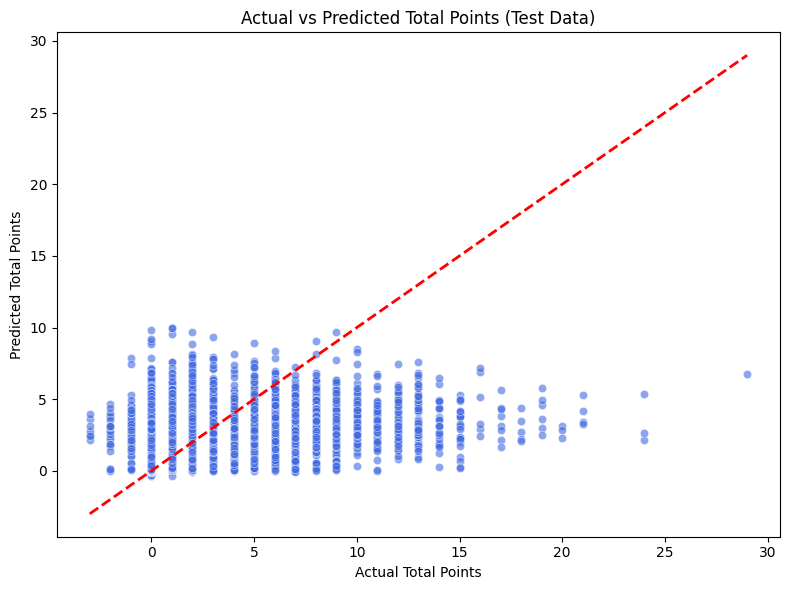

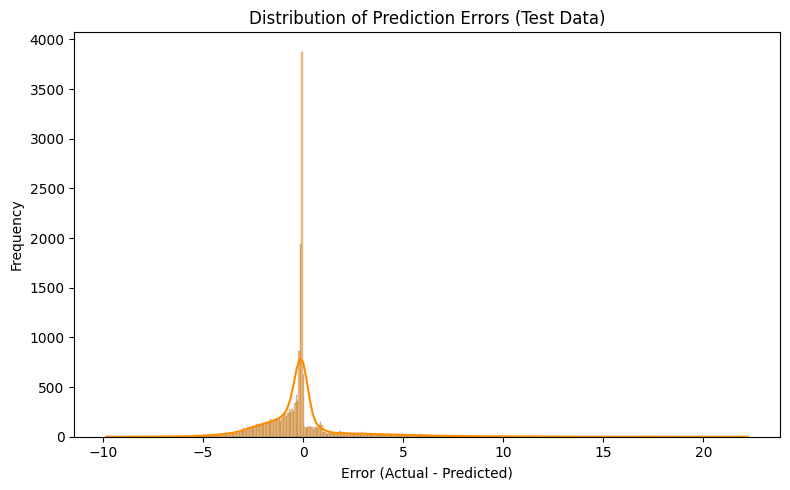

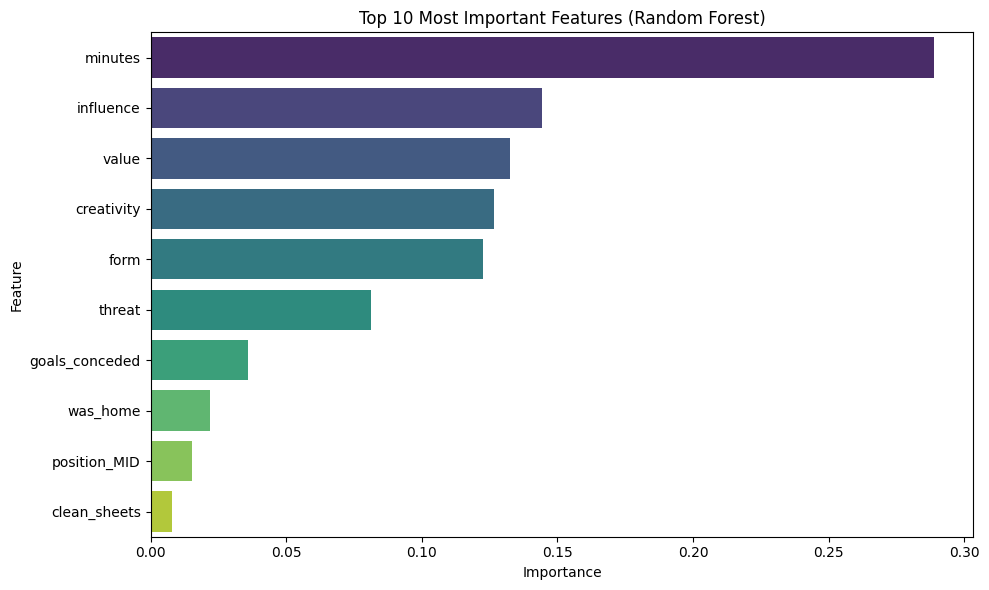


 Trained RandomForestRegressor model saved as random_forest_model.joblib


In [9]:
# Split data into training (80%) and testing (20%)
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Further split training into training (80%) and validation (20%)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size=0.2, random_state=42
)

# Initialize RandomForestRegressor model
model = RandomForestRegressor(
    n_estimators=100,
    random_state=42,
    n_jobs=-1
)

# --- Training ---
model.fit(X_train, y_train)

# --- Validation Performance ---
y_val_pred = model.predict(X_val)
mae_val = mean_absolute_error(y_val, y_val_pred)
mse_val = mean_squared_error(y_val, y_val_pred)
rmse_val = np.sqrt(mse_val)
r2_val = r2_score(y_val, y_val_pred)

print("Validation Performance:")
print(f"  MAE  (Validation): {mae_val:.4f}")
print(f"  MSE  (Validation): {mse_val:.4f}")
print(f"  RMSE (Validation): {rmse_val:.4f}")
print(f"  R²   (Validation): {r2_val:.4f}")

# --- Final Training on Full Training Data ---
model.fit(X_train_full, y_train_full)

# --- Test Performance (Unseen Data) ---
y_test_pred = model.predict(X_test)
mae_test = mean_absolute_error(y_test, y_test_pred)
mse_test = mean_squared_error(y_test, y_test_pred)
rmse_test = np.sqrt(mse_test)
r2_test = r2_score(y_test, y_test_pred)

print("\n Test Performance (Unseen Data):")
print(f"  MAE  (Test): {mae_test:.4f}")
print(f"  MSE  (Test): {mse_test:.4f}")
print(f"  RMSE (Test): {rmse_test:.4f}")
print(f"  R²   (Test): {r2_test:.4f}")

# --- Visualizations ---

#Actual vs Predicted (Test Data)
plt.figure(figsize=(8,6))
sns.scatterplot(x=y_test, y=y_test_pred, alpha=0.6, color='royalblue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel("Actual Total Points")
plt.ylabel("Predicted Total Points")
plt.title("Actual vs Predicted Total Points (Test Data)")
plt.tight_layout()
plt.show()

#Distribution of Prediction Errors
errors = y_test - y_test_pred
plt.figure(figsize=(8,5))
sns.histplot(errors, kde=True, color='darkorange')
plt.title("Distribution of Prediction Errors (Test Data)")
plt.xlabel("Error (Actual - Predicted)")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

#Feature Importance Plot
feature_importances = pd.Series(model.feature_importances_, index=X.columns)
top_features = feature_importances.sort_values(ascending=False).head(10)

plt.figure(figsize=(10,6))
sns.barplot(x=top_features.values, y=top_features.index, palette='viridis')
plt.title("Top 10 Most Important Features (Random Forest)")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

# Save model
joblib.dump(model, "random_forest_model.joblib")
print("\n Trained RandomForestRegressor model saved as random_forest_model.joblib")


 Validation Performance (Linear Regression):
  MAE  (Validation): 1.2261
  MSE  (Validation): 4.5681
  RMSE (Validation): 2.1373
  R²   (Validation): 0.2870

 Test Performance (Linear Regression):
  MAE  (Test): 1.2316
  MSE  (Test): 4.6436
  RMSE (Test): 2.1549
  R²   (Test): 0.2817


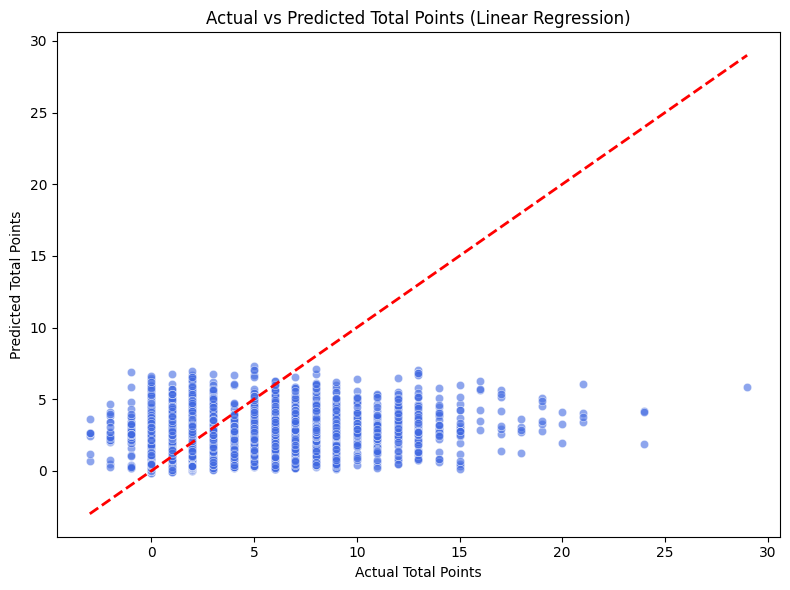

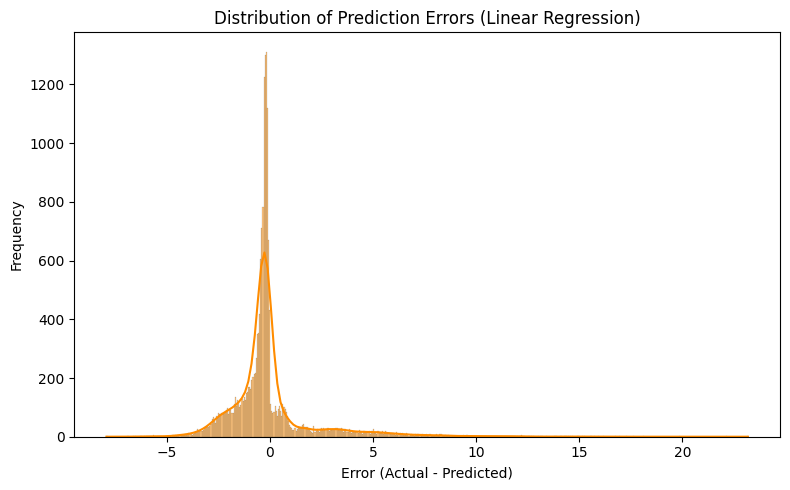

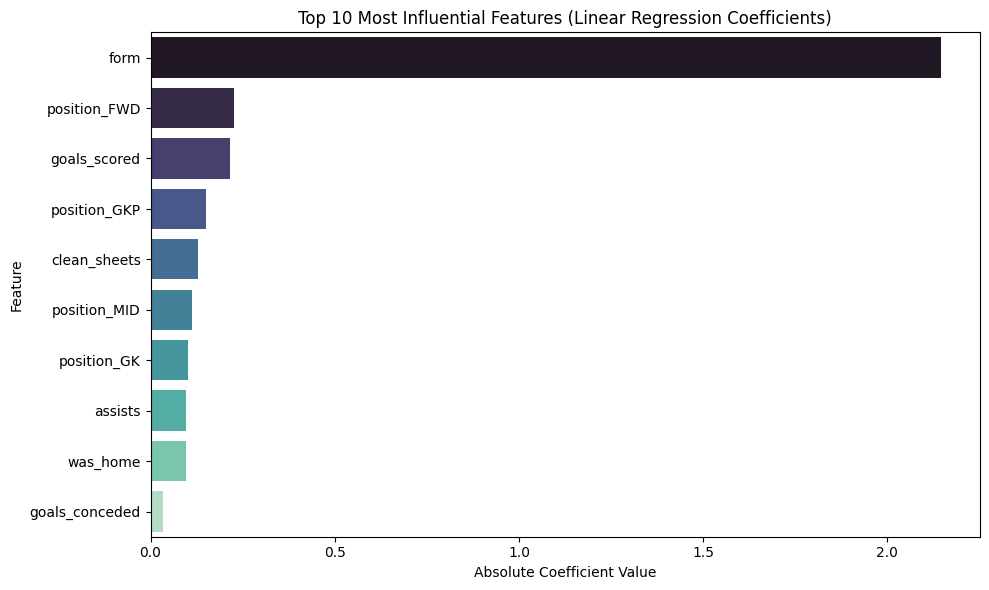


 Trained LinearRegression model saved as linear_regression_model.joblib


In [10]:
# Split data into training (80%) and testing (20%)
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Further split training into training (80%) and validation (20%)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size=0.2, random_state=42
)

# Initialize and train the Linear Regression model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# --- Validation Performance ---
y_val_pred = lr_model.predict(X_val)
mae_val = mean_absolute_error(y_val, y_val_pred)
mse_val = mean_squared_error(y_val, y_val_pred)
rmse_val = np.sqrt(mse_val)
r2_val = r2_score(y_val, y_val_pred)

print("\n Validation Performance (Linear Regression):")
print(f"  MAE  (Validation): {mae_val:.4f}")
print(f"  MSE  (Validation): {mse_val:.4f}")
print(f"  RMSE (Validation): {rmse_val:.4f}")
print(f"  R²   (Validation): {r2_val:.4f}")

# --- Final Training on Full Training Data ---
lr_model.fit(X_train_full, y_train_full)

# --- Test Performance (Unseen Data) ---
y_test_pred = lr_model.predict(X_test)
mae_test = mean_absolute_error(y_test, y_test_pred)
mse_test = mean_squared_error(y_test, y_test_pred)
rmse_test = np.sqrt(mse_test)
r2_test = r2_score(y_test, y_test_pred)

print("\n Test Performance (Linear Regression):")
print(f"  MAE  (Test): {mae_test:.4f}")
print(f"  MSE  (Test): {mse_test:.4f}")
print(f"  RMSE (Test): {rmse_test:.4f}")
print(f"  R²   (Test): {r2_test:.4f}")

# --- Visualizations ---

#Actual vs Predicted (Test Data)
plt.figure(figsize=(8,6))
sns.scatterplot(x=y_test, y=y_test_pred, alpha=0.6, color='royalblue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel("Actual Total Points")
plt.ylabel("Predicted Total Points")
plt.title("Actual vs Predicted Total Points (Linear Regression)")
plt.tight_layout()
plt.show()

# Distribution of Prediction Errors
errors = y_test - y_test_pred
plt.figure(figsize=(8,5))
sns.histplot(errors, kde=True, color='darkorange')
plt.title("Distribution of Prediction Errors (Linear Regression)")
plt.xlabel("Error (Actual - Predicted)")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

#Feature Coefficients (Feature Importance Equivalent)
coefficients = pd.Series(lr_model.coef_, index=X.columns)
top_features = coefficients.abs().sort_values(ascending=False).head(10)

plt.figure(figsize=(10,6))
sns.barplot(x=top_features.values, y=top_features.index, palette='mako')
plt.title("Top 10 Most Influential Features (Linear Regression Coefficients)")
plt.xlabel("Absolute Coefficient Value")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

# Save the trained model
joblib.dump(lr_model, "linear_regression_model.joblib")
print("\n Trained LinearRegression model saved as linear_regression_model.joblib")



 Model Performance Comparison (Test Data):


,Model,MAE,MSE,RMSE,R²
0,Random Forest,1.226126,4.568144,2.137322,0.287003
1,Linear Regression,1.231596,4.643580,2.154897,0.281747


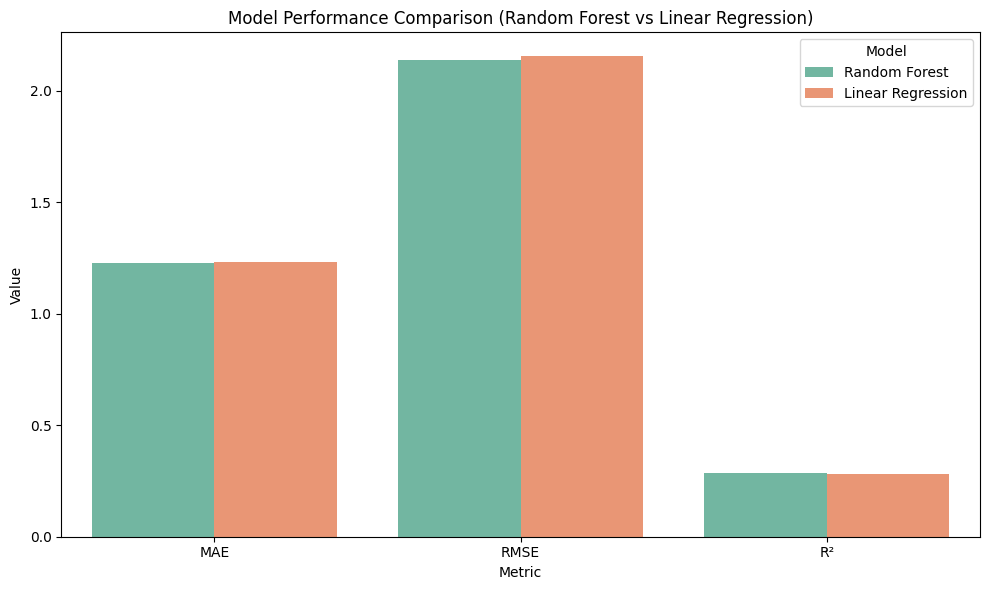

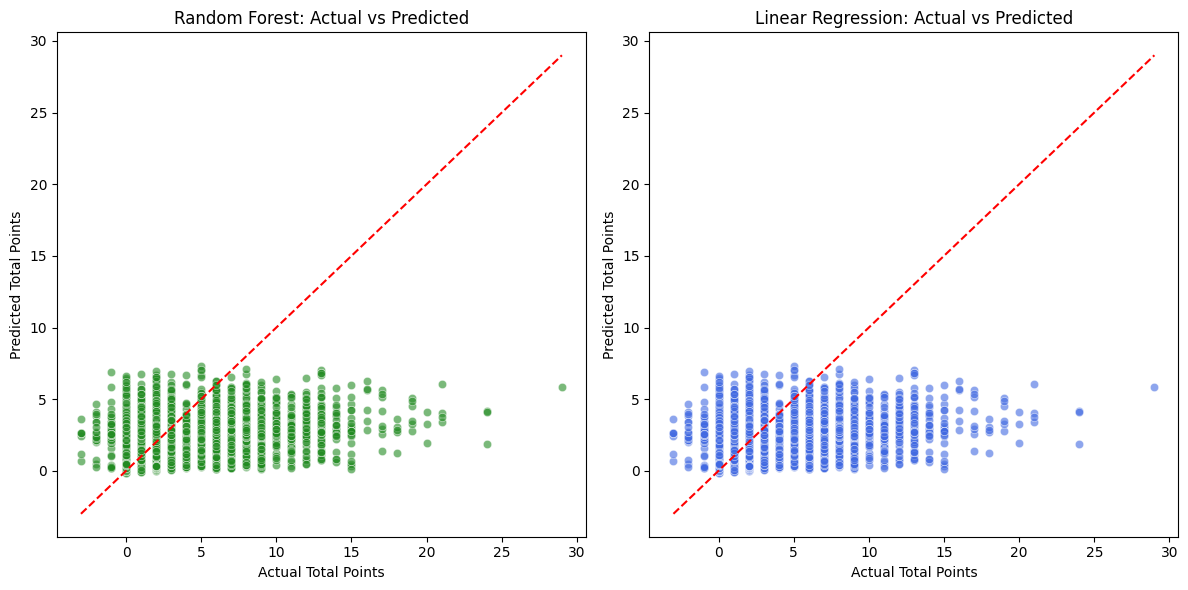

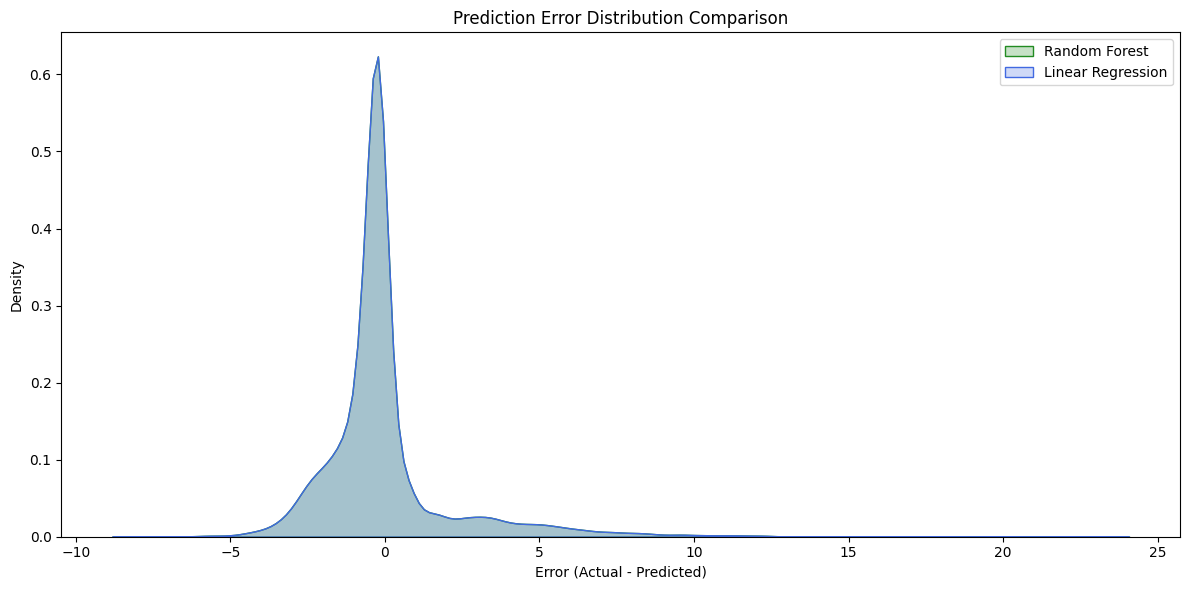

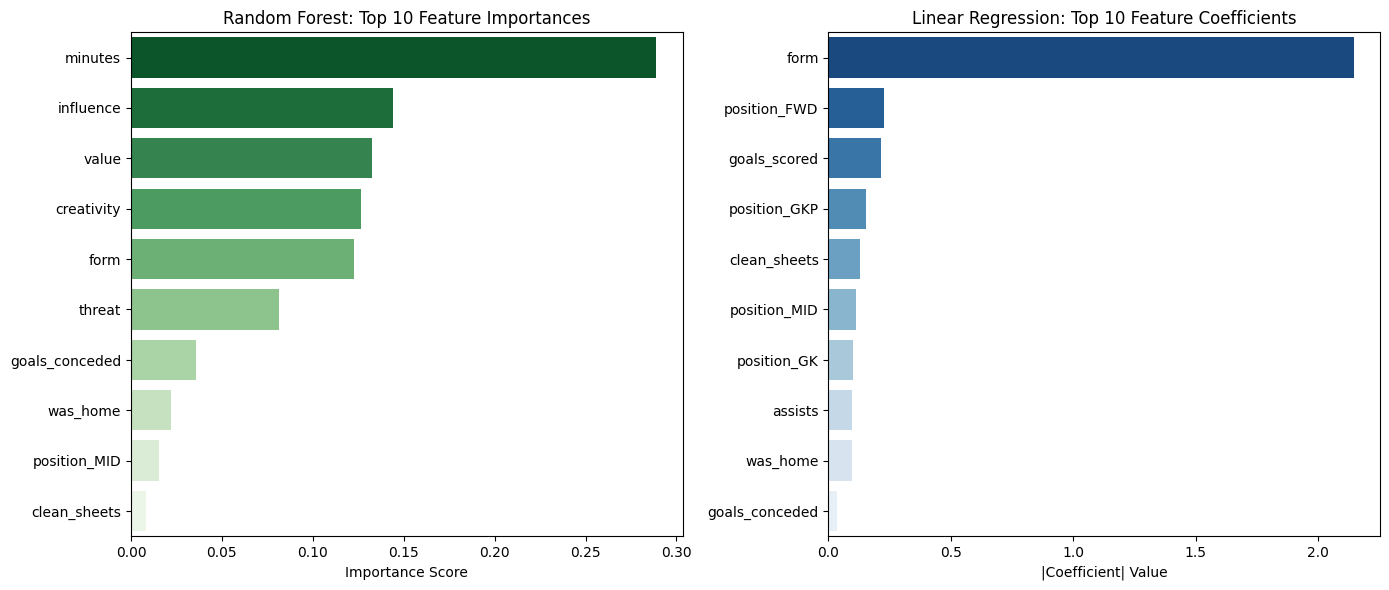

In [11]:
# --- Collect Metrics ---

comparison_df = pd.DataFrame({
    "Model": ["Random Forest", "Linear Regression"],
    "MAE": [mae_val, mae_test],
    "MSE": [mse_val, mse_test],
    "RMSE": [rmse_val, rmse_test],
    "R²": [r2_val, r2_test]
})

print("\n Model Performance Comparison (Test Data):")
display(comparison_df)

# ---  Bar Plot: Metric Comparison ---
metrics_to_plot = ["MAE", "RMSE", "R²"]
plt.figure(figsize=(10,6))
comparison_melted = comparison_df.melt(id_vars="Model", value_vars=metrics_to_plot, var_name="Metric", value_name="Value")

sns.barplot(x="Metric", y="Value", hue="Model", data=comparison_melted, palette="Set2")
plt.title("Model Performance Comparison (Random Forest vs Linear Regression)")
plt.tight_layout()
plt.show()

# --- Actual vs Predicted Comparison ---
plt.figure(figsize=(12,6))

# Random Forest
plt.subplot(1, 2, 1)
sns.scatterplot(x=y_test, y=y_test_pred, alpha=0.6, color="forestgreen")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "r--")
plt.title("Random Forest: Actual vs Predicted")
plt.xlabel("Actual Total Points")
plt.ylabel("Predicted Total Points")

# Linear Regression
plt.subplot(1, 2, 2)
sns.scatterplot(x=y_test, y=y_test_pred, alpha=0.6, color="royalblue")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "r--")
plt.title("Linear Regression: Actual vs Predicted")
plt.xlabel("Actual Total Points")
plt.ylabel("Predicted Total Points")

plt.tight_layout()
plt.show()

# --- Error Distribution Comparison ---
plt.figure(figsize=(12,6))

sns.kdeplot(y_test - y_test_pred, fill=True, label="Random Forest", color="forestgreen")
sns.kdeplot(y_test - y_test_pred, fill=True, label="Linear Regression", color="royalblue")

plt.title("Prediction Error Distribution Comparison")
plt.xlabel("Error (Actual - Predicted)")
plt.ylabel("Density")
plt.legend()
plt.tight_layout()
plt.show()

# ---  Feature Importance vs Coefficients ---

# Random Forest feature importances
rf_importances = pd.Series(model.feature_importances_, index=X.columns)
rf_top = rf_importances.abs().sort_values(ascending=False).head(10)

# Linear Regression coefficients
lr_coeffs = pd.Series(lr_model.coef_, index=X.columns)
lr_top = lr_coeffs.abs().sort_values(ascending=False).head(10)

fig, axes = plt.subplots(1, 2, figsize=(14,6))

sns.barplot(x=rf_top.values, y=rf_top.index, ax=axes[0], palette="Greens_r")
axes[0].set_title("Random Forest: Top 10 Feature Importances")
axes[0].set_xlabel("Importance Score")

sns.barplot(x=lr_top.values, y=lr_top.index, ax=axes[1], palette="Blues_r")
axes[1].set_title("Linear Regression: Top 10 Feature Coefficients")
axes[1].set_xlabel("|Coefficient| Value")

plt.tight_layout()
plt.show()


# 5. Model Explainability (XAI)
To ensure transparency and gain deeper insights into the model\`s decision-making process, Explainable AI (XAI) techniques are applied. This section uses SHAP (SHapley Additive exPlanations) and LIME (Local Interpretable Model-agnostic Explanations) to interpret the model\`s predictions.

## SHAP Analysis
SHAP values quantify the contribution of each feature to a prediction, providing a global understanding of feature importance and how features influence the model output. Summary plots and dependence plots are generated to visualize these insights.

In [12]:
print(df.columns)

Index(['season_x', 'name', 'assists', 'bonus', 'bps', 'clean_sheets',
       'creativity', 'element', 'fixture', 'goals_conceded', 'goals_scored',
       'ict_index', 'influence', 'kickoff_time', 'minutes', 'opponent_team',
       'opp_team_name', 'own_goals', 'penalties_missed', 'penalties_saved',
       'red_cards', 'round', 'saves', 'selected', 'team_a_score',
       'team_h_score', 'threat', 'total_points', 'transfers_balance',
       'transfers_in', 'transfers_out', 'value', 'was_home', 'yellow_cards',
       'GW', 'form', 'upcoming_total_points', 'position_FWD', 'position_GK',
       'position_GKP', 'position_MID'],
      dtype='object')


In [13]:
# Load the trained model and feature names
model = joblib.load("random_forest_model.joblib")
with open("model_features.txt", "r") as f:
    feature_names = [line.strip() for line in f]


# Ensure X has the correct columns for SHAP
features_for_shap = [col for col in feature_names if col != "upcoming_total_points"]
X_shap = df[features_for_shap].copy()
X_shap.columns = feature_names

# Create a SHAP explainer object
explainer = shap.TreeExplainer(model)

# Calculate SHAP values for a smaller subset of the data for performance
sample_size = 500
if len(X_shap) > sample_size:
    X_sample = X_shap.sample(n=sample_size, random_state=42)
else:
    X_sample = X_shap

print(f"Calculating SHAP values for {len(X_sample)} samples...")
shap_values = explainer.shap_values(X_sample)
print("SHAP values calculated.")


print("SHAP explainability complete.")

Calculating SHAP values for 500 samples...
SHAP values calculated.
SHAP explainability complete.


Generating SHAP summary plots...


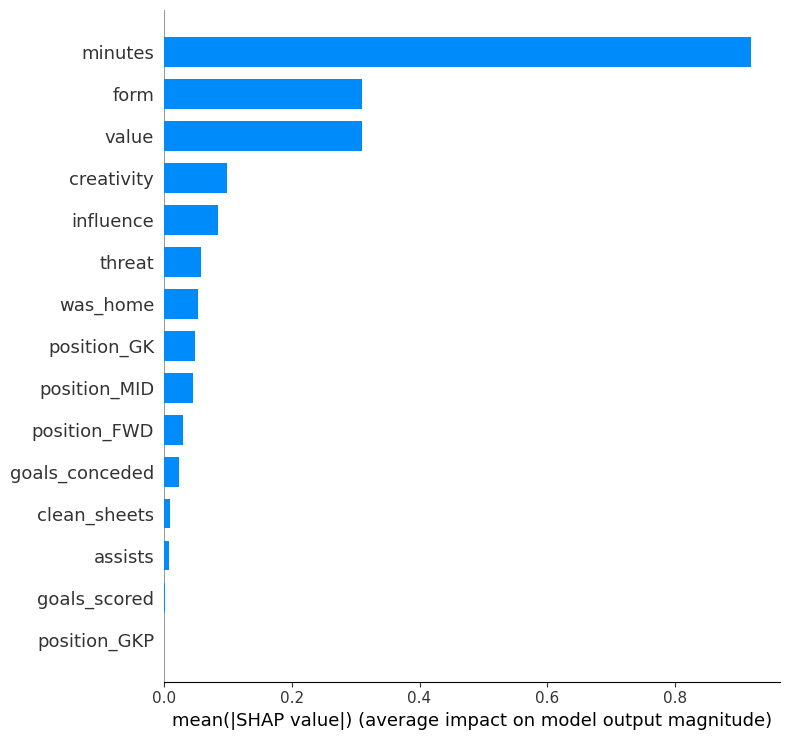

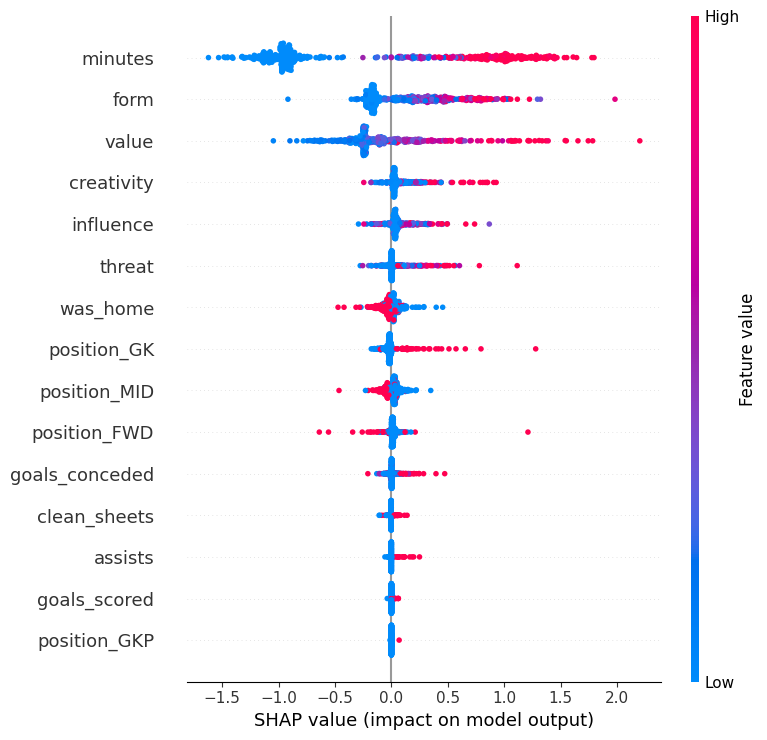

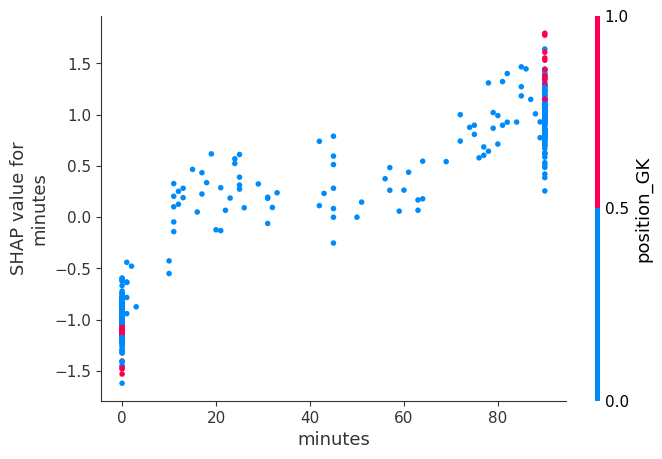

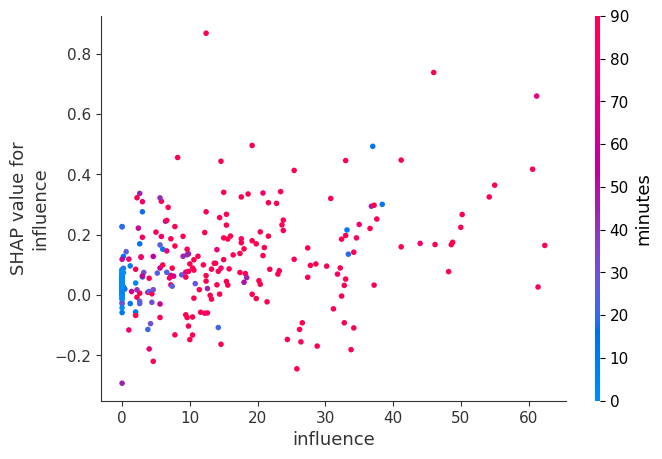

In [14]:
print("Generating SHAP summary plots...")

# Bar summary plot
shap.summary_plot(shap_values, X_sample, plot_type="bar", show=True)
plt.show()

# Beeswarm summary plot
shap.summary_plot(shap_values, X_sample, show=True)
plt.show()

# Dependence plots for top 2 features

feature_importances = pd.Series(model.feature_importances_, index=feature_names)
top_features = feature_importances.nlargest(2).index.tolist()

for feature in top_features:
    shap.dependence_plot(feature, shap_values, X_sample, show=True)
    plt.show()

## LIME Explanation
LIME provides local interpretability by explaining individual predictions. It creates a local, interpretable model around a specific prediction to show which features are most influential for that particular outcome.

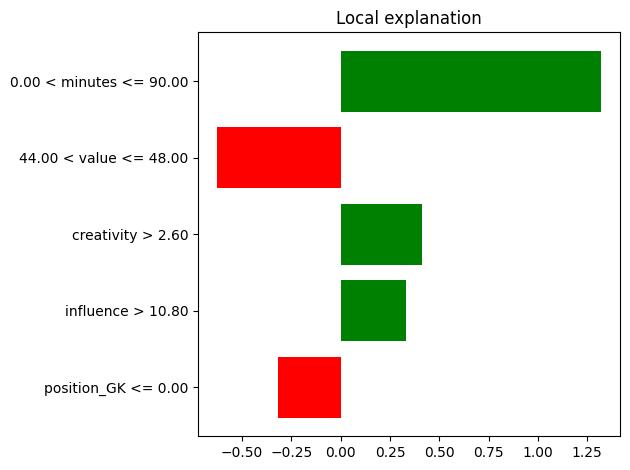

LIME explainability complete.


In [15]:
# Fix: wrap the model prediction so it re-adds feature names
predict_fn = lambda x: model.predict(pd.DataFrame(x, columns=X.columns))

# Create LIME explainer
explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X.values,
    feature_names=X.columns,
    class_names=["upcoming_total_points"],
    mode="regression"
)

# Select one random instance to explain
instance_to_explain = X.sample(n=1, random_state=42).iloc[0]

# Generate explanation
explanation = explainer.explain_instance(
    data_row=instance_to_explain.values,
    predict_fn=predict_fn,   
    num_features=5
)

# Visualize and save
fig = explanation.as_pyplot_figure()
fig.tight_layout()
fig.savefig("lime_explanation.png")
plt.show()
plt.close()

print("LIME explainability complete.")

# 6. Inference Function
This section defines a Python function `predict_upcoming_points` that takes a dictionary of player features as input and returns the predicted `upcoming_total_points`. It handles necessary preprocessing steps like one-hot encoding internally, making it ready for deployment or direct use.

In [16]:
def predict_upcoming_points(input_data: dict):
    """Predicts upcoming total points for a player based on input features.

    Args:
        input_data (dict): A dictionary containing player features.
                           Example: {
                               "goals_scored": 0,
                               "assists": 0,
                               "clean_sheets": 0,
                               "goals_conceded": 0,
                               "minutes": 90,
                               "was_home": True,
                               "creativity": 10.0,
                               "influence": 15.0,
                               "threat": 5.0,
                               "value": 4.5,
                               "form": 0.5,
                               "position": "DEF" # This will be one-hot encoded
                           }

    Returns:
        float: Predicted upcoming total points.
    """
    # Load the trained model and feature names
    model = joblib.load("random_forest_model.joblib")
    with open("model_features.txt", "r") as f:
        feature_names = [line.strip() for line in f]

    # Create a DataFrame from the input data
    input_df = pd.DataFrame([input_data])

    # One-hot encode the position feature, ensuring all possible position columns are present
    all_positions = [col.replace("position_", "") for col in feature_names if col.startswith("position_")]
    for pos in all_positions:
        input_df[f"position_{pos}"] = (input_df["position"] == pos).astype(int)
    input_df.drop(columns=["position"], inplace=True, errors='ignore')

    # Ensure all features used during training are present in the input_df
    for feature in feature_names:
        if feature not in input_df.columns:
            input_df[feature] = 0

    # Reorder columns to match the training data
    input_df = input_df[feature_names]

    # Make prediction
    prediction = model.predict(input_df)[0]

    return prediction

# Example usage
sample_input = {
    "goals_scored": 0,
    "assists": 0,
    "clean_sheets": 0,
    "goals_conceded": 0,
    "minutes": 90,
    "was_home": True,
    "creativity": 10.0,
    "influence": 15.0,
    "threat": 5.0,
    "value": 4.5,
    "form": 0.5,
    "position": "DEF"
}
predicted_points = predict_upcoming_points(sample_input)
print(f"Predicted upcoming total points: {predicted_points:.2f}")

sample_input_fwd = {
    "goals_scored": 1,
    "assists": 0,
    "clean_sheets": 0,
    "goals_conceded": 0,
    "minutes": 90,
    "was_home": True,
    "creativity": 25.0,
    "influence": 30.0,
    "threat": 40.0,
    "value": 10.0,
    "form": 1.2,
    "position": "FWD"
}
predicted_points_fwd = predict_upcoming_points(sample_input_fwd)
print(f"Predicted upcoming total points for FWD: {predicted_points_fwd:.2f}")

Predicted upcoming total points: 3.08
Predicted upcoming total points for FWD: 3.30
